<a href="https://colab.research.google.com/github/GiannisAlvanos/Emergenshit-backend/blob/main/Bathia_Mathisi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Εργασία στο μάθημα της Βαθιάς Μάθησης
Βήμα 0


In [1]:
!pip install medmnist --quiet
import sys
print(sys.executable)
print(sys.path)

/usr/bin/python3
['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython']


In [4]:
!pip install medmnist==2.2.2
import medmnist
print(medmnist.__version__)
from medmnist import INFO
import pprint

pprint.pprint(INFO['octmnist'])

  Attempting uninstall: medmnist
    Found existing installation: medmnist 3.0.2
    Uninstalling medmnist-3.0.2:
      Successfully uninstalled medmnist-3.0.2


3.0.2
{'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'MD5_128': '0a97e76651ace45c5d943ee3f65b63ae',
 'MD5_224': 'abc493b6d529d5de7569faaef2773ba3',
 'MD5_64': 'e229e9440236b774d9f0dfef9d07bdaf',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid '
                'optical coherence tomography (OCT) images for retinal '
                'diseases. The dataset is comprised of 4 diagnosis categories, '
                'leading to a multi-class classification task. We split the '
                'source training set with a ratio of 9:1 into training and '
                'validation set, and use its source validation set as the test '
                'set. The source images are gray-scale, and their sizes are '
                '(384−1,536)×(277−512). We center-crop the images and resize '
                'them into 1×28×28.',
 'label': {'0': 'choroidal neovascularization',
           '1': 'diabetic macular edema',
           '2': 'drusen',
           '3': 'normal'},
 '

In [11]:
import pprint
pprint.pprint(info)

{'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid '
                'optical coherence tomography (OCT) images for retinal '
                'diseases. The dataset is comprised of 4 diagnosis categories, '
                'leading to a multi-class classification task. We split the '
                'source training set with a ratio of 9:1 into training and '
                'validation set, and use its source validation set as the test '
                'set. The source images are gray-scale, and their sizes are '
                '(384−1,536)×(277−512). We center-crop the images and resize '
                'them into 1×28×28.',
 'label': {'0': 'choroidal neovascularization',
           '1': 'diabetic macular edema',
           '2': 'drusen',
           '3': 'normal'},
 'license': 'CC BY 4.0',
 'n_channels': 1,
 'n_samples': {'test': 1000, 'train': 97477, 'val': 10832},
 'python_class': 'OCTMNIST',
 'task': 'multi-cla

In [12]:
# Instantiate the specific dataset class for the full training set
train_ds_full = DataClass(split='train', transform=transform, download=True)

print(f"Length of the full training dataset: {len(train_ds_full)}")

Length of the full training dataset: 97477


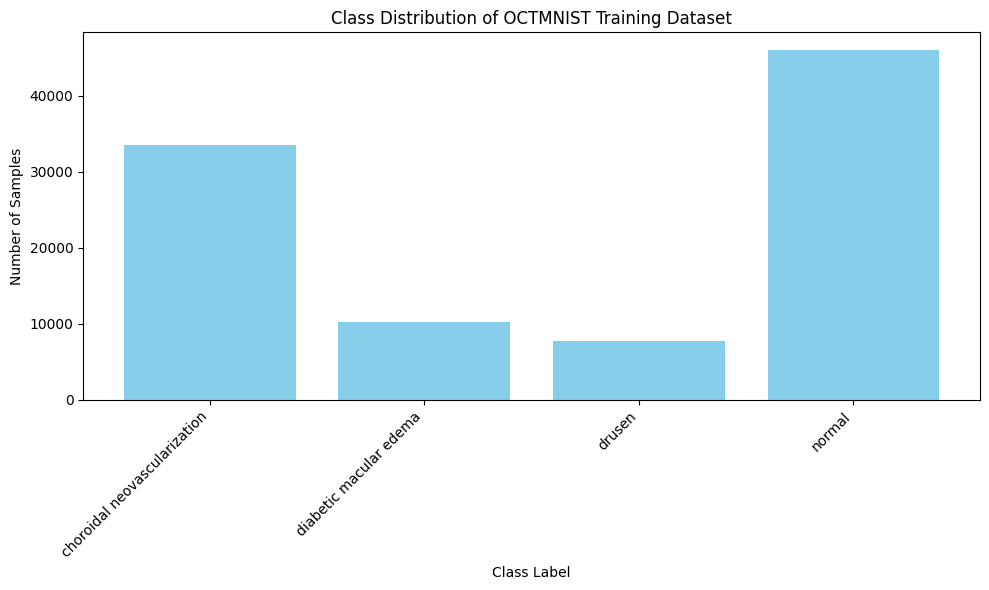

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Extract all labels from the training dataset
labels = [label.item() for _, label in train_ds]

# Count the occurrences of each label
class_counts = np.bincount(labels)

# Get class names from the info dictionary
class_names = [info['label'][str(i)] for i in range(len(class_counts))]

# Create a bar chart to visualize the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution of OCTMNIST Training Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Βημα 1

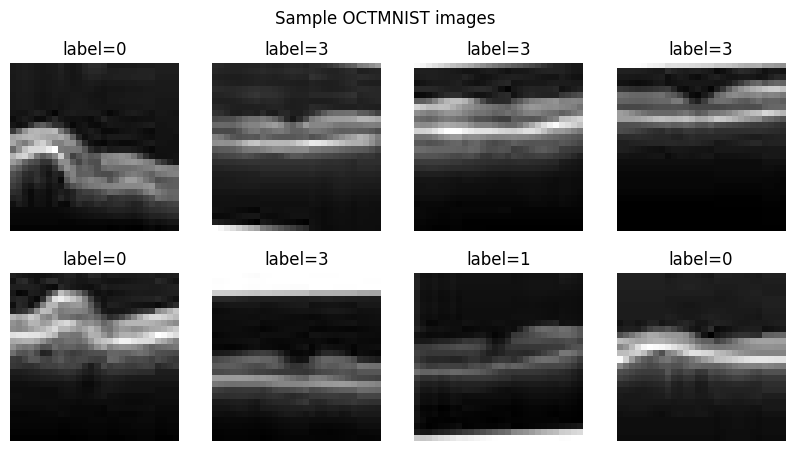

In [14]:
from medmnist import INFO
import medmnist # Import medmnist to access dataset classes dynamically
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

DATASET = 'octmnist'
info = INFO[DATASET]

img_size = 28
n_channels = info['n_channels']
n_classes = len(info['label'])

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)), # Remove transforms.ToPILImage() as MedMNIST already returns PIL Images
    transforms.ToTensor()
])

# Get the specific dataset class from the medmnist module using its name
DataClass = getattr(medmnist, info['python_class'])

# Instantiate the specific dataset class
train_ds = DataClass(split='train', transform=transform, download=True)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    img, label = train_ds[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"label={int(label[0])}") # Access the scalar value from the array
    ax.axis('off')

plt.suptitle("Sample OCTMNIST images")
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO
import numpy as np
import random

# --- 1. Setup & Reproducibility (Σπορά/Seeds) ---
def set_seed(seed):
    """Sets seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. Hyperparameters & Dataset Info ---
DATASET = 'octmnist'
info = INFO[DATASET]
img_size = 28
n_channels = info['n_channels'] # 1 (Grayscale)
n_classes = len(info['label']) # 4
BATCH_SIZE = 64 # Προτεινόμενο batch size [cite: 36]
NUM_EPOCHS = 30 # Προτεινόμενος αριθμός εποχών [cite: 36]

# --- 3. Data Loading & Normalization ---

# Τα MedMNIST datasets έχουν μέση τιμή και τυπική απόκλιση 0.5/0.5 (προτεινόμενο).
# Mean/Std για normalization [cite: 55]
# Για το OCTMNIST, οι τιμές είναι: mean=[0.1130], std=[0.2198] (ή 0.5/0.5 για απλοποίηση)
# Θα χρησιμοποιήσουμε τις απλοποιημένες τιμές 0.5/0.5 όπως προτείνεται συχνά στα tutorials.
data_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]) # Προσθήκη Normalization
])

# Φόρτωση Dataset
DataClass = getattr(medmnist, info['python_class'])

train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

# Δημιουργία DataLoaders [cite: 36]
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Έλεγχος μεγεθών
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# --- 4. CNN Architecture from Scratch ---

class BasicCNN(nn.Module):
    """
    CNN Architecture with at least 3 convolutional blocks.
    Allows for experimentation with BatchNorm, LayerNorm, and Dropout.
    """
    def __init__(self, in_channels, num_classes, use_batchnorm=False, use_layernorm=False, dropout_rate=0.0):
        super(BasicCNN, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.use_layernorm = use_layernorm

        # Block 1: Conv -> ReLU -> [BN/LN] -> MaxPool
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1) # 32 filters [cite: 25]
        self.bn1 = nn.BatchNorm2d(32) if use_batchnorm else None
        self.ln1 = nn.LayerNorm([32, img_size//2, img_size//2]) if use_layernorm else None # LN after maxpool
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output size: 14x14

        # Block 2: Conv -> ReLU -> [BN/LN] -> MaxPool
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 64 filters [cite: 25]
        self.bn2 = nn.BatchNorm2d(64) if use_batchnorm else None
        self.ln2 = nn.LayerNorm([64, img_size//4, img_size//4]) if use_layernorm else None # LN after maxpool
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output size: 7x7

        # Block 3: Conv -> ReLU -> [BN/LN] -> MaxPool (Optional but good for 3rd block)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 128 filters [cite: 25]
        self.bn3 = nn.BatchNorm2d(128) if use_batchnorm else None
        self.ln3 = nn.LayerNorm([128, img_size//4, img_size//4]) if use_layernorm else None # Keep size 7x7

        # Calculate flattened features size: 128 filters * (7x7 spatial size)
        # Note: If adding a third MaxPool, size becomes (3x3 or 4x4)
        # Let's keep 7x7 output for simplicity of calculation, without 3rd MaxPool.
        flattened_size = 128 * (img_size // 4) * (img_size // 4) # 128 * 7 * 7 = 6272

        # Fully Connected Layer (Classifier Head) [cite: 28]
        self.fc = nn.Linear(flattened_size, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        if self.bn1: x = self.bn1(x) # BatchNorm after Conv2d [cite: 29]
        x = nn.ReLU()(x)
        x = self.pool1(x)
        if self.ln1 and not self.use_batchnorm: x = self.ln1(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2) # LayerNorm at the end of block [cite: 29]

        # Block 2
        x = self.conv2(x)
        if self.bn2: x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        if self.ln2 and not self.use_batchnorm: x = self.ln2(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

        # Block 3 (Optional: just Conv/ReLU, no MaxPool)
        x = self.conv3(x)
        if self.bn3: x = self.bn3(x)
        x = nn.ReLU()(x)
        if self.ln3 and not self.use_batchnorm: x = self.ln3(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

        # Flatten and Fully Connected Layer
        x = x.view(x.size(0), -1) # Flatten
        x = self.dropout(x) # Dropout on FC layer
        x = self.fc(x)
        return x

Train size: 97477, Validation size: 10832, Test size: 1000


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Ορισμός της συνάρτησης απώλειας
criterion = nn.CrossEntropyLoss()
# Το DEVICE έχει οριστεί ως 'cuda' ή 'cpu' στο Μέρος Α

# --- Συνάρτηση Αξιολόγησης ---
def evaluate_model(model, data_loader, device):
    """
    Evaluates the model on a given data loader (Validation or Test).
    Returns loss, accuracy, and all true/predicted labels for confusion matrix.
    """
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            # Το MedMNIST επιστρέφει labels ως (Batch, 1), τα χρειαζόμαστε ως (Batch,)
            inputs, labels = inputs.to(device), labels.squeeze().long().to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy, all_labels, all_predictions

# --- Συνάρτηση Εκπαίδευσης (με Validation) ---
def train_model(model, optimizer, train_loader, val_loader, num_epochs, device, model_name):
    """
    Main training loop for the CNN.
    """
    model.to(device)

    # Αποθήκευση ιστορικού
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print(f"\n--- Starting Training for: {model_name} ---")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_corrects = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.squeeze().long().to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs.data, 1)
            train_corrects += (preds == labels).sum().item()
            train_total += labels.size(0)

        # Υπολογισμός μέσης απώλειας και ακρίβειας
        epoch_train_loss = train_loss / train_total
        epoch_train_acc = train_corrects / train_total

        # Αξιολόγηση στο Validation set
        epoch_val_loss, epoch_val_acc, _, _ = evaluate_model(model, val_loader, device)

        # Αποθήκευση στο history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

    return model, history

# --- Συνάρτηση Σχεδίασης Confusion Matrix ---
def plot_confusion_matrix(all_labels, all_predictions, class_names, model_name):
    """Plots the confusion matrix using Seaborn."""
    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
# Ορισμός ονομάτων κλάσεων για το OCTMNIST
CLASS_NAMES = ['Normal', 'CNV', 'DME', 'Drusen']

# --- Συνδυασμοί για Πειραματισμό ---
experiments = [
    {
        'name': '1_Baseline_LR1e3',
        'use_batchnorm': False,
        'use_layernorm': False,
        'dropout_rate': 0.0,
        'lr': 1e-3,
        'weight_decay': 0.0
    },
    {
        'name': '2_BatchNorm_LR5e4',
        'use_batchnorm': True,
        'use_layernorm': False,
        'dropout_rate': 0.0,
        'lr': 5e-4,
        'weight_decay': 0.0
    },
    {
        'name': '3_Dropout05_WD1e4_LR1e3',
        'use_batchnorm': False,
        'use_layernorm': False,
        'dropout_rate': 0.5,
        'lr': 1e-3,
        'weight_decay': 1e-4
    },
    # ΠΡΟΣΟΧΗ: Μπορείτε να προσθέσετε κι άλλους συνδυασμούς εδώ!
]

results = {}
all_histories = {}

for exp in experiments:
    print(f"\n=======================================================")
    print(f"Εκτελώντας Πείραμα: {exp['name']}")
    print(f"BN: {exp['use_batchnorm']}, Dropout: {exp['dropout_rate']}, WD: {exp['weight_decay']}, LR: {exp['lr']}")
    print(f"=======================================================")

    # 1. Σχεδίαση Νέου Μοντέλου
    model = BasicCNN(
        in_channels=n_channels,
        num_classes=n_classes,
        use_batchnorm=exp['use_batchnorm'],
        use_layernorm=exp['use_layernorm'], # Μπορείτε να το βάλετε True σε ένα πείραμα
        dropout_rate=exp['dropout_rate']
    )

    # 2. Ορισμός Optimizer (με Weight Decay/L2 regularization)
    optimizer = optim.Adam(
        model.parameters(),
        lr=exp['lr'],
        weight_decay=exp['weight_decay']
    )

    # 3. Εκπαίδευση
    trained_model, history = train_model(
        model,
        optimizer,
        train_loader,
        val_loader,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        model_name=exp['name']
    )
    all_histories[exp['name']] = history

    # 4. Αξιολόγηση στο Test Set
    test_loss, test_acc, true_labels, pred_labels = evaluate_model(trained_model, test_loader, DEVICE)

    # 5. Αποθήκευση Αποτελεσμάτων
    results[exp['name']] = {
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'true_labels': true_labels,
        'pred_labels': pred_labels
    }

    print(f"Test Accuracy for {exp['name']}: {test_acc:.4f}")

    # 6. Σχεδίαση Confusion Matrix
    plot_confusion_matrix(true_labels, pred_labels, CLASS_NAMES, exp['name'])

    # 7. (Προαιρετικό) Σχεδίαση Curves (Loss & Accuracy)
    # Θα το κάνετε στην αναφορά σας, αλλά μπορείτε να χρησιμοποιήσετε το history

print("\n--- Συνολικά Αποτελέσματα Test Set ---")
for name, res in results.items():
    print(f"Model: {name}, Test Accuracy: {res['test_accuracy']:.4f}")


Εκτελώντας Πείραμα: 1_Baseline_LR1e3
BN: False, Dropout: 0.0, WD: 0.0, LR: 0.001

--- Starting Training for: 1_Baseline_LR1e3 ---
Epoch 1/30 - Train Loss: 0.6294, Train Acc: 0.7714 | Val Loss: 0.4487, Val Acc: 0.8436
Epoch 2/30 - Train Loss: 0.4314, Train Acc: 0.8486 | Val Loss: 0.3964, Val Acc: 0.8592
Epoch 3/30 - Train Loss: 0.3782, Train Acc: 0.8674 | Val Loss: 0.3662, Val Acc: 0.8739
Epoch 4/30 - Train Loss: 0.3457, Train Acc: 0.8791 | Val Loss: 0.3286, Val Acc: 0.8842
Epoch 5/30 - Train Loss: 0.3194, Train Acc: 0.8876 | Val Loss: 0.3339, Val Acc: 0.8862
Epoch 6/30 - Train Loss: 0.2985, Train Acc: 0.8952 | Val Loss: 0.3101, Val Acc: 0.8907
Epoch 7/30 - Train Loss: 0.2797, Train Acc: 0.9027 | Val Loss: 0.3207, Val Acc: 0.8882
Epoch 8/30 - Train Loss: 0.2626, Train Acc: 0.9075 | Val Loss: 0.2940, Val Acc: 0.8984
Epoch 9/30 - Train Loss: 0.2479, Train Acc: 0.9134 | Val Loss: 0.2868, Val Acc: 0.9011
Epoch 10/30 - Train Loss: 0.2361, Train Acc: 0.9173 | Val Loss: 0.2858, Val Acc: 0.902